# College Board Analysis Task

Steven Peterson (Sep 30, 2025)

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

sns.set_style("ticks",
              {"axes.grid": True,
              "axes.spines.right": False,
              "axes.spines.top": False})

Loading in schema info for quick reference

In [2]:
# schema_info = pd.read_csv(os.path.join("..", "data", "enrollments_schema.csv"),
#                           delimiter='\t',
#                           names=['variable', 'description'],
#                           index_col=0
#                          ).to_dict()['description']

# schema_info['private']


## Task 1

**Task 1:** *Please load the entire dataset. In the following, assume that the variable “iau_id1” identifies unique institutions and that enrollments are estimated by the variable “students5_estimated”. There is no need to incorporate any additional data sources.*

I am using convert_dtypes to automatically convert each column to its best dtype. An alternative approach would be to specify dtypes for each column in the read_csv function.

In [3]:
df_enrollments = pd.read_csv(os.path.join("..", "data", "enrollments.csv"),
                             low_memory = False).convert_dtypes()

df_enrollments.dropna(subset = ['iau_id1', 'students5_estimated'], inplace = True)

### Exploratory data analysis

I plotted the number of unique institutions per country using the iau_id1 column. This plot shows that there are only a few countries with >400 institutions.

I also plotted enrollments (students5_estimated) vs income group to understand how enrollments change over time. Interestingly, lower middle and upper middle income groups have an initial dip in enrollments at 1960 and then increase quickly. Because this average gives equal weighting to each school in an income group, these averages are skewed toward the few countries with the most institutions.

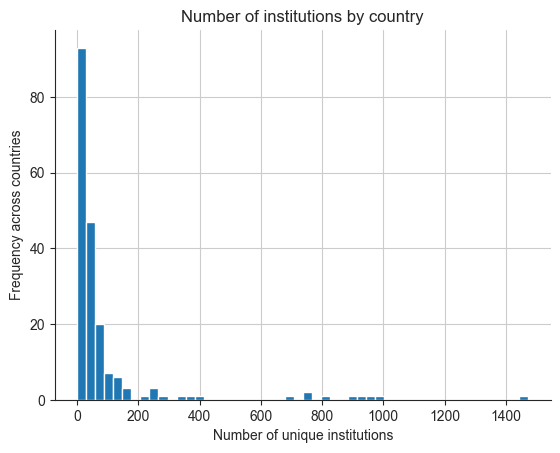

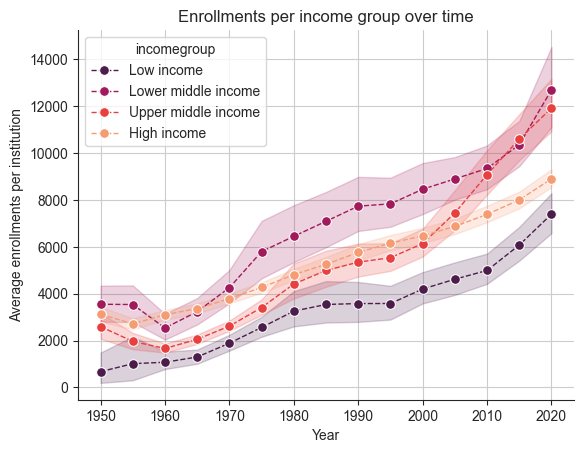

In [4]:
df_enrollments.groupby('country')['iau_id1'].nunique().plot.hist(bins=50)
plt.gca().set(xlabel='Number of unique institutions',
              ylabel='Frequency across countries',
              title='Number of institutions by country')
plt.show()


sns.lineplot(df_enrollments,
             x = 'year',
             y = 'students5_estimated',
             hue='incomegroup',
             palette = 'rocket',
             hue_order = ['Low income', 'Lower middle income', 'Upper middle income', 'High income'],
             marker = 'o', lw = 1, linestyle = '--', markersize=7, errorbar=('ci', 95)
            )
plt.gca().set(xlabel='Year',
              ylabel='Average enrollments per institution',
              title='Enrollments per income group over time')
plt.show()


Descriptive statistics for all numeric and categorical data is shown below. Note that several boolean variables are present in the numeric data (e.g. phd_granting and private01).

In [5]:
display(df_enrollments.describe().round(1))

display(df_enrollments.select_dtypes(include='string[python]').describe())

,foundedyr,yrclosed,private01,phd_granting,m_granting,b_granting,divisions,total_fields,unique_fields,specialized,merger,noiau,year,students5_interpolated,students5_extrapolated,students5_estimated
count,142819.0,412.0,142819.0,142819.0,20527.0,20527.0,20527.0,20527.0,20527.0,142819.0,142819.0,142819.0,142819.0,48837.0,94387.0,142819.0
mean,1941.6,2007.7,0.5,0.1,0.5,0.8,6.9,26.2,22.2,0.2,0.0,0.0,1995.6,11356.8,8722.6,6804.2
std,81.4,14.0,0.5,0.2,0.5,0.4,7.1,33.0,23.3,0.4,0.2,0.1,19.0,36551.6,29712.1,24359.4
min,859.0,1952.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,2.0,0.0,0.0
25%,1924.0,2004.0,0.0,0.0,0.0,1.0,3.0,7.0,7.0,0.0,0.0,0.0,1980.0,1846.0,1088.0,1148.0
50%,1961.0,2014.0,0.0,0.0,1.0,1.0,5.0,16.0,15.0,0.0,0.0,0.0,2000.0,5095.0,3290.0,2705.0
75%,1986.0,2016.0,1.0,0.0,1.0,1.0,8.0,33.0,30.0,0.0,0.0,0.0,2010.0,12248.0,8967.5,6492.0
max,2020.0,2022.0,1.0,1.0,1.0,1.0,119.0,661.0,257.0,1.0,1.0,1.0,2020.0,2673333.0,2673333.0,2673333.0


,country,countrycode,region,incomegroup,iau_id,iau_id1,eng_name,orig_name,coordinates,latitude,longitude
count,142819,142231,142231,142231,142819,142819,142819,127740,127649,127649,127649
unique,193,187,7,4,16923,16955,16761,15171,14656,14655,14653
top,united states,USA,East Asia and Pacific,High income,��IAU-015671��,��IAU-015671��-1,National University,(BU),"43.7840347, -79.2331848",43.7840347,-79.2331848
freq,18712,18712,40902,57329,15,15,71,124,647,647,647


## Task 2

**Task 2:** *What civil or geopolitical events do you think you might be able to detect with this data set? Create one of more visualizations and some basic analysis to make some initial observations about this event as it impacted university enrollments. It is ok if the event turns out not to be observable in the data.*

### Civil event: US integration of schools

***Hypothesis:*** The integration of US schools following Brown v. Board of Education in 1954 decreased public school enrollments in the USA due to white flight to private institutions.

To test this, I am plotting the total average enrollment over time for public and private schools in the USA and showing where Brown v. Board fell relative to the data.


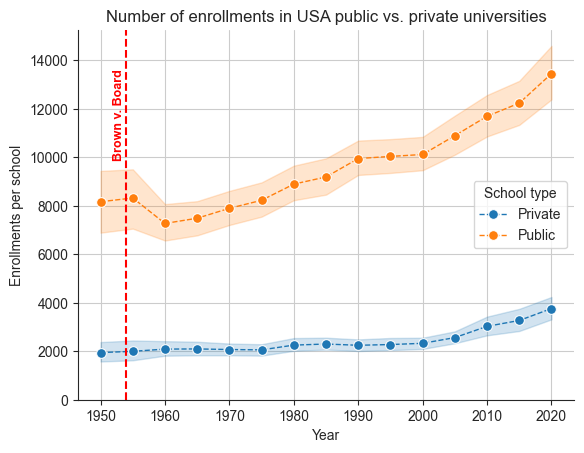

In [6]:
df_usa = df_enrollments.query("country == 'united states'").copy()
df_usa["school_type"] = df_usa.private01.astype(str).replace({'0': 'Public', '1': 'Private'})

sns.lineplot(df_usa,
             x = "year",
             y = "students5_estimated", hue='school_type',
             linestyle='--', marker='o', lw=1, markersize=7, errorbar=('ci', 95)
            )
plt.gca().set(xlabel='Year',
              ylabel='Enrollments per school',
              title='Number of enrollments in USA public vs. private universities')
plt.ylim(ymin=0)
plt.axvline(1954, color='r', linestyle='--')
plt.text(x=1952, y=10000, s='Brown v. Board', rotation=90, color='r', size=9, weight='bold')
plt.legend(title = 'School type')
plt.show()


**Model:**
I visually see a decline in public school enrollment from 1955 to 1960. To test if this is significant, I use a diff-in-diff regression model for the data from 1955 and 1960.

**Assumptions:**
Because enrollments are measured every 5 years and the delays in integration rollout, I am assuming that 1955 represents pre-integration enrollments and 1960 represents post-integration enrollments.
I am also assuming parallel trends between private and public schools over time, which I am verifying using Pearson correlation from 1960 onwards (r=0.92).

**Result:**
The model finds a decrease in public school enrollment after integration relative to private school enrollment (integration:public_school = -1141). However, this result is not statistically significant (p = 0.099). I suspect that there is too much variance due to confounding factors such as geography (eg. schools in the southern US integrated slower than elsewhere). However, the model currently does not quite support my hypothesis.


In [7]:
print('Diff-in-diff analysis')
df_usa_did = df_usa.copy().query("year in [1955, 1960]")
df_usa_did['integration'] = df_usa_did['year'].apply(lambda x: 0 if x <= 1955 else 1)
df_usa_did['public_school'] = 1 - df_usa_did['private01']
model = smf.ols("students5_estimated ~ integration * public_school", df_usa_did).fit()
display(model.summary().tables[1])


print('\nCheck for parallel trends assumption')
public_private_corr = df_usa.query("year >= 1960").groupby(['school_type', 'year']) \
                                                  .agg(ave_enrollment = ('students5_estimated', 'mean')) \
                                                  .reset_index().pivot(columns='school_type',
                                                                       index='year',
                                                                       values='ave_enrollment'
                                                                      ).corr().iloc[0, 1]
print(f'Public v. private enrollments r ={public_private_corr: 0.2f}')


Diff-in-diff analysis


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1996.2205,335.116,5.957,0.000,1338.889,2653.552
integration,91.7356,416.397,0.220,0.826,-725.029,908.500
public_school,6323.6411,582.866,10.849,0.000,5180.345,7466.937
integration:public_school,-1141.0015,691.199,-1.651,0.099,-2496.792,214.789



Check for parallel trends assumption
Public v. private enrollments r = 0.92


### Geopolitical event: Collapse of the Soviet Union

**Hypothesis:** Institution enrollments decrease in Russia following the fall of the Soviet Union in 1989 due to decreased funding and institutional upheaval.

First, checking that russian federation describes the USSR and russia (no multiple names)

In [8]:
print('Country name for Russia/USSR:')
print(df_enrollments.query('country.str.contains("russia")', engine="python").country.unique())

print('\nCountry names with russian federation code')
ccode_russia = df_enrollments.query('country == "russian federation"')['countrycode'].unique()

for cc in ccode_russia:
    print(df_enrollments.query('countrycode == "' + cc + '"')['country'].unique())

Country name for Russia/USSR:
<StringArray>
['russian federation']
Length: 1, dtype: string

Country names with russian federation code
<StringArray>
['russian federation']
Length: 1, dtype: string


**Result:**
Plotting private vs. public school enrollments for russia. I don't see any drop in public school enrollments around 1989. It is possible that any dip in enrollment was short-lived and does not show up in a 5-year average. Regardless, the data does not appear to support my hypothesis.

Interestingly, the data does show the fall of the Soviet Union because *private institutions appear starting in the 1995 enrollment data*. This makes sense because the USSR would have only allowed public universities. There is also an interesting dip in private enrollments in 2010 that may also be related to geopolitical events.


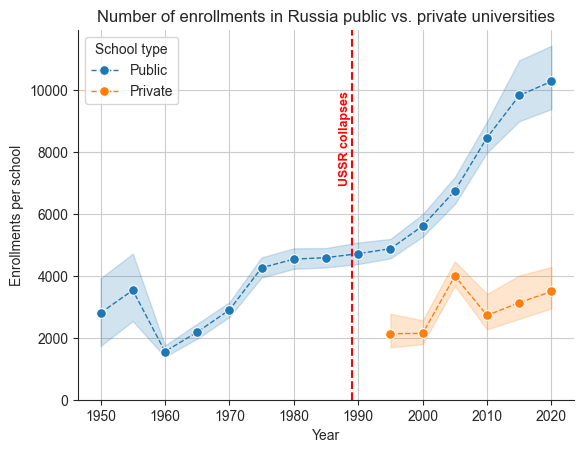

In [9]:
df_ussr = df_enrollments.query("country == 'russian federation'").copy()
df_ussr["school_type"] = df_ussr.private01.astype(str).replace({'0': 'Public', '1': 'Private'})

sns.lineplot(df_ussr,
             x = "year",
             y = "students5_estimated", hue='school_type',
             linestyle='--', marker='o', lw=1, markersize=7, errorbar=('ci', 95)
            )
plt.gca().set(xlabel='Year',
              ylabel='Enrollments per school',
              title='Number of enrollments in Russia public vs. private universities')
plt.ylim(ymin=0)
plt.legend(title = 'School type')
plt.axvline(1989, color='r', linestyle='--')
plt.text(x=1987, y=7000, s='USSR collapses', rotation=90, color='r', size=9, weight='bold')
plt.show()


## Task 3

**Task 3:** *Your client wants to know how GDP is related to university enrollment. Join the provided data set “Countries GDP 1960-2020.csv” onto the enrollments one and briefly describe the relationship you see.*

### Join the data

I decided to inner join the tables using the country code and year columns. Inner join ignores some of the rows in the GDP table belonging to aggregate countries (eg. Sub-Saharan Africa). I chose country code because it seemed less prone to different spellings compared to country name. Doing this will remove countries without a country code. To format the GDP table with a year column, I used pd.melt(). 

In [10]:
# Load GDP data and reformat to be 3 columns: country code, year, and gdp
df_gdp = pd.read_csv(os.path.join("..", "data", "Countries GDP 1960-2020.csv"))
df_gdp = df_gdp.melt(id_vars = ['Country Name', 'Country Code'], var_name='year', value_name='GDP')
df_gdp.drop(columns = ['Country Name'], inplace = True)
df_gdp.rename(columns={'Country Code': 'countrycode'}, inplace=True)
df_gdp.year = pd.to_numeric(df_gdp.year)

# Inner join onto enrollments
df_joined = pd.merge(df_enrollments, df_gdp, how='inner', on=['countrycode', 'year'])

# Group by country
df_joined = df_joined.groupby(["year",
                               "countrycode"]).agg(sum_students = ("students5_estimated", "sum"),
                                           GDP = ("GDP", "first")).reset_index()


Descriptive statistics for the 4 joined features of interest.

In [11]:
display(df_joined.describe().round(1))

display(df_joined.select_dtypes(include='object').describe())


,year,sum_students,GDP
count,1052.0,1052.0,1.052000e+03
mean,1990.8,630417.0,2.969558e+11
std,18.5,1846299.7,1.383966e+12
min,1960.0,3.0,3.457931e+07
25%,1975.0,5812.2,2.379945e+09
50%,1990.0,58752.0,1.137284e+10
75%,2005.0,348193.5,8.792207e+10
max,2020.0,20435355.0,2.100000e+13


,countrycode
count,1052
unique,84
top,AUS
freq,13


### Data preprocessing

One issue is that GDP is skewed with a few countries with really high GDP compared to the rest. Using a log transformation improves the distribution.

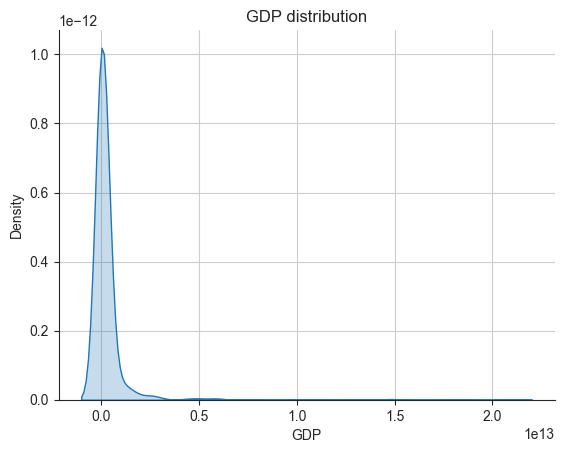

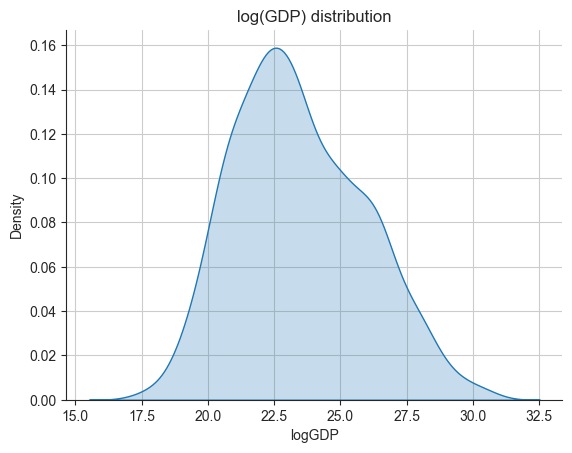

In [12]:
sns.kdeplot(df_joined, x = 'GDP', fill = True)
plt.title("GDP distribution")
plt.show()

df_joined['logGDP'] = np.log(df_joined['GDP'])
sns.kdeplot(df_joined, x = 'logGDP', fill = True)
plt.title("log(GDP) distribution")
plt.show()


This skew issue seems to affect the number of enrollments as well.

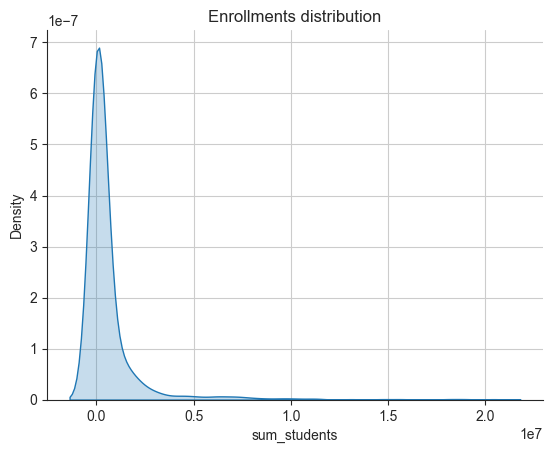

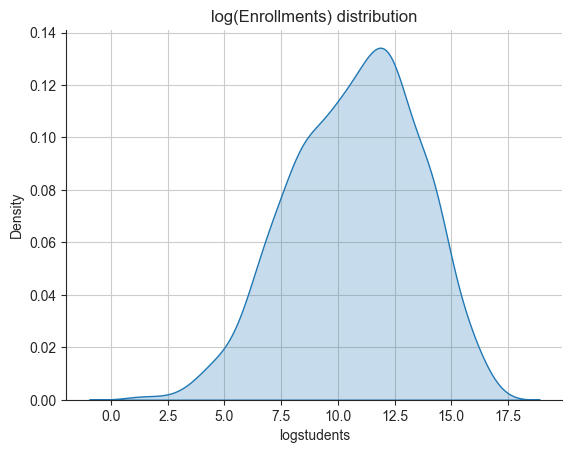

In [13]:
sns.kdeplot(df_joined, x = 'sum_students', fill = True)
plt.title("Enrollments distribution")
plt.show()

df_joined['logstudents'] = np.log(df_joined['sum_students'])
sns.kdeplot(df_joined, x = 'logstudents', fill = True)
plt.title("log(Enrollments) distribution")
plt.show()


One other issue is that there are repeated measurements with missing data. Ideally, we want to only keep countries with no missing data. Looking at the countries with missing data below, I decided to remove 1960 from the dataset (many countries with missing data) as well as all countries with missing data in 1965 (since no other countries have missing data from 1965 onwards).

In [14]:
final_countries = df_joined.query("year == 2020").countrycode.unique()
for yr in range(1960, 2020, 5):
    current_countries = df_joined.query("year == " + str(yr)).countrycode.unique()
    missing_countries = np.setdiff1d(final_countries, current_countries)
    print(f'{yr}: {', '.join(sorted(missing_countries))}')

# Remove 1960 and countries with missing data in 1965
df_joined_cleaned = df_joined.query("year > 1960")

countries1965 = df_joined.query("year == 1965").countrycode.unique()
missing_countries1965 = np.setdiff1d(final_countries, countries1965)
df_joined_cleaned = df_joined_cleaned[~df_joined_cleaned.countrycode.isin(missing_countries1965)]
print(f'\nNumber of remaining countries: {df_joined_cleaned.countrycode.nunique()}')


1960: BEN, BHS, BLZ, BWA, CAF, COG, GUY, KNA, NER, PNG, RWA, SUR, SWZ, SYC, TCD, ZMB
1965: BEN, BHS, BLZ, FJI, KNA, SUR, SYC
1970: BHS, BLZ, KNA, SYC
1975: BLZ, KNA, SYC
1980: BLZ, KNA, SYC
1985: BLZ, KNA, SYC
1990: SYC
1995: SYC
2000: SYC
2005: SYC
2010: 
2015: 

Number of remaining countries: 77


### Modeling GDP vs enrollment

With the data cleaned, we see a signficant positive relationship between GDP and student enrollment. The model explains 78% of the data variance.

This model can be interpreted as saying that a 1% increase in GDP leads to ~0.94% increase in enrollment.

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-11.2799,0.388,-29.034,0.000,-12.042,-10.517
logGDP,0.9422,0.016,57.869,0.000,0.910,0.974


R^2:  0.78


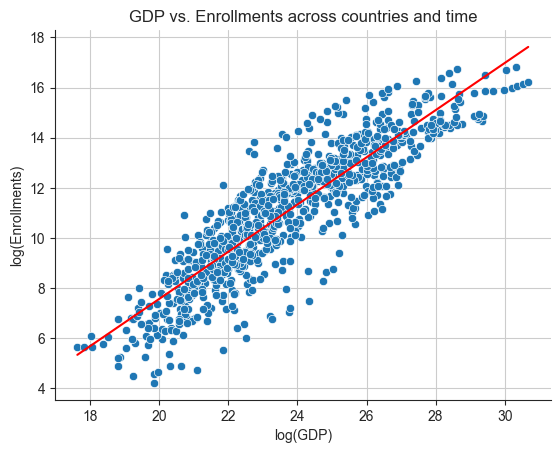

In [15]:
model = smf.ols("logstudents ~ logGDP", data = df_joined_cleaned).fit()
results = model.summary().tables[1]
display(results)
print(f'R^2: {model.rsquared: .2f}')

sns.scatterplot(df_joined_cleaned, x='logGDP', y='logstudents')

x = np.linspace(df_joined_cleaned.logGDP.min(),
                df_joined_cleaned.logGDP.max(),
                100
               )
plt.plot(x, model.params.iat[0] + model.params.iat[1] * x, color = 'r')
plt.gca().set(xlabel='log(GDP)',
              ylabel='log(Enrollments)',
              title='GDP vs. Enrollments across countries and time')
plt.show()

**Fixed effects model:**
The above model includes repeated measures for each country that violates the independence assumption for linear regression. To improve the model, I created a linear regression model with the mean value for log(enrollment) and log(GDP) subtracted out. This is equivalent to creating a fixed effects model and controlling for country-specific information that does not vary with time.

This model has a slightly more modest fit: *1% increase in GDP leads to ~0.88% increase in enrollment*. This is what I would present to the client. Further analyses could be to segment countries by location, climate, income category, etc. if there are more specific questions about the data.


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-2.533e-16,0.019,-1.34e-14,1.000,-0.037,0.037
logGDP,0.8765,0.015,57.850,0.000,0.847,0.906


R^2:  0.78


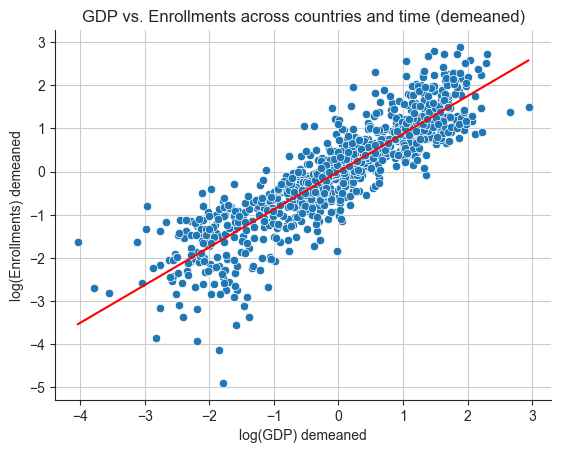

In [16]:
df_joined_timedemeaned = df_joined_cleaned.copy()
df_country_ave = df_joined_cleaned.groupby('countrycode').agg(mean_students = ('logstudents', 'mean'),
                                                              mean_gdp = ('logGDP', 'mean')
                                                             ).reset_index()
df_joined_timedemeaned = pd.merge(df_joined_cleaned, df_country_ave, how = 'left', on = 'countrycode')
df_joined_timedemeaned['logstudents'] -= df_joined_timedemeaned['mean_students']
df_joined_timedemeaned['logGDP'] -= df_joined_timedemeaned['mean_gdp']

model = smf.ols("logstudents ~ logGDP", data = df_joined_timedemeaned).fit()
results = model.summary().tables[1]
display(results)
print(f'R^2: {model.rsquared: .2f}')

sns.scatterplot(df_joined_timedemeaned, x='logGDP', y='logstudents')

x = np.linspace(df_joined_timedemeaned.logGDP.min(),
                df_joined_timedemeaned.logGDP.max(),
                100
               )
plt.plot(x, model.params.iat[0] + model.params.iat[1] * x, color = 'r')
plt.gca().set(xlabel='log(GDP) demeaned',
              ylabel='log(Enrollments) demeaned',
              title='GDP vs. Enrollments across countries and time (demeaned)')
plt.show()
